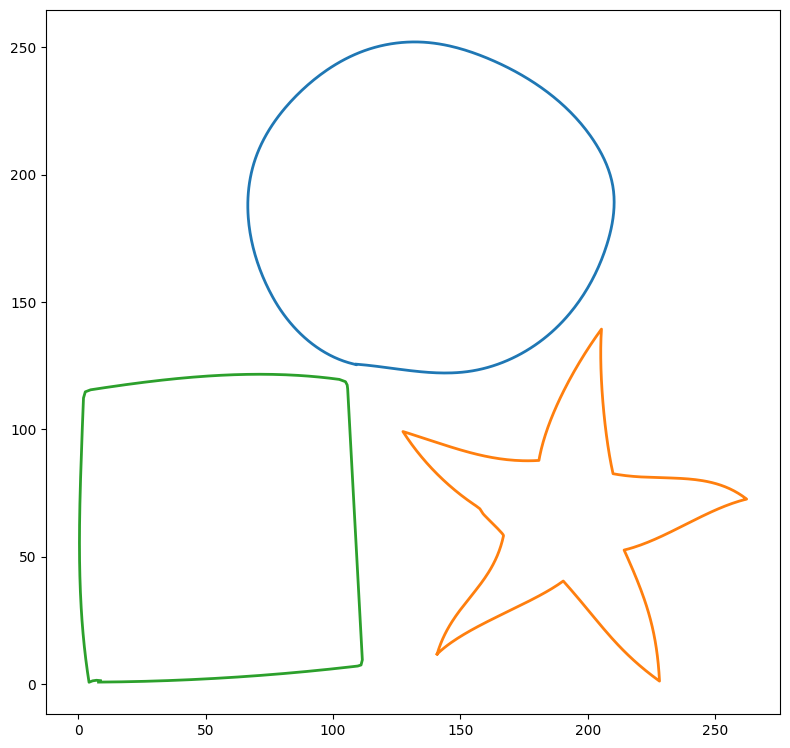

In [23]:
import numpy as np
import matplotlib.pyplot as plt


def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs


def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect("equal")
    plt.show()


# Example usage
csv_path = "./isolated.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)
plot(paths_XYs)

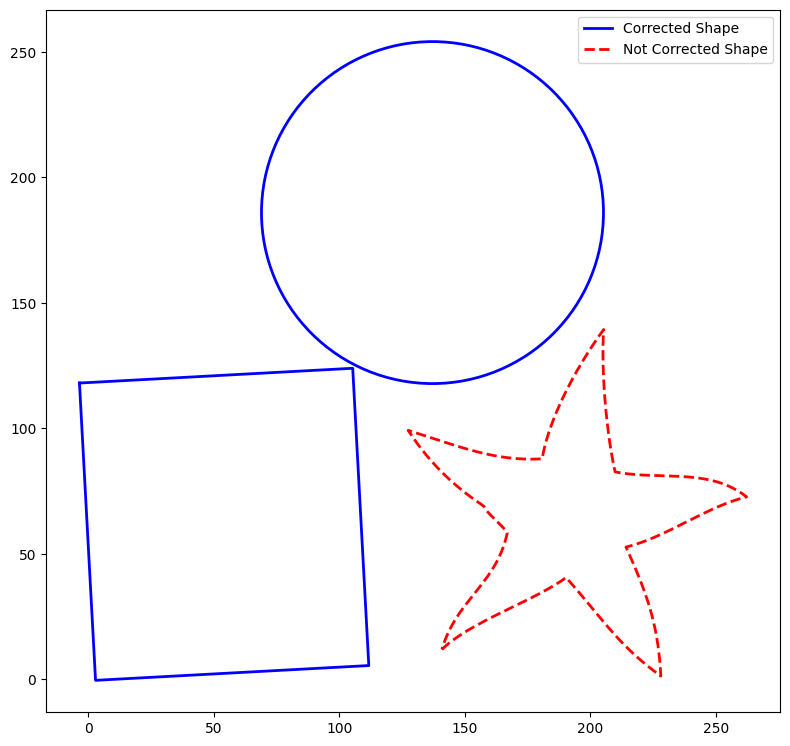

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
import cv2

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def cluster_shapes(XY, eps=10, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(XY)
    labels = clustering.labels_
    clusters = [XY[labels == i] for i in range(max(labels) + 1)]
    return clusters

def detect_circle(XY):
    def calc_R(xc, yc):
        return np.sqrt((XY[:, 0] - xc)**2 + (XY[:, 1] - yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = np.mean(XY, axis=0)
    center, _ = leastsq(f_2, center_estimate)
    radius = calc_R(*center).mean()
    return center, radius

def detect_rectangle(XY):
    XY = XY.astype(np.float32)
    rect = cv2.minAreaRect(XY)
    box = cv2.boxPoints(rect)
    return box

def detect_shape(XY):
    if len(XY) < 5:
        return None

    center, radius = detect_circle(XY)
    error = np.sqrt(np.sum((np.sqrt((XY[:, 0] - center[0])**2 + (XY[:, 1] - center[1])**2) - radius)**2))
    
    if error < 1 * radius:  # Tolerance for circular shape
        return 'circle', center, radius

    rect = detect_rectangle(XY)
    rect_area = cv2.contourArea(rect.astype(np.float32))
    hull = cv2.convexHull(XY.astype(np.float32))
    hull_area = cv2.contourArea(hull)
    if np.abs(rect_area - hull_area) < 0.1 * hull_area:  # Tolerance for rectangle
        return 'rectangle', rect

    return 'other', XY

def redraw_shape(shape_info, ax):
    if shape_info[0] == 'circle':
        center, radius = shape_info[1], shape_info[2]
        circle = plt.Circle(center, radius, color='b', fill=False, linewidth=2, label='Corrected Shape')
        ax.add_patch(circle)
    elif shape_info[0] == 'rectangle':
        rect = shape_info[1]
        ax.plot(*np.append(rect, [rect[0]], axis=0).T, 'b-', linewidth=2, label='Corrected Shape')
    elif shape_info[0] == 'other':
        XY = shape_info[1]
        ax.plot(XY[:, 0], XY[:, 1], 'r--', linewidth=2, label='Not Corrected Shape')

def plot(paths_XYs, eps=10, min_samples=5):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            clusters = cluster_shapes(XY, eps=eps, min_samples=min_samples)
            for cluster in clusters:
                shape_info = detect_shape(cluster)
                if shape_info:
                    redraw_shape(shape_info, ax)
    ax.set_aspect("equal")
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    plt.show()

# Example usage
csv_path = "./isolated.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)
plot(paths_XYs)

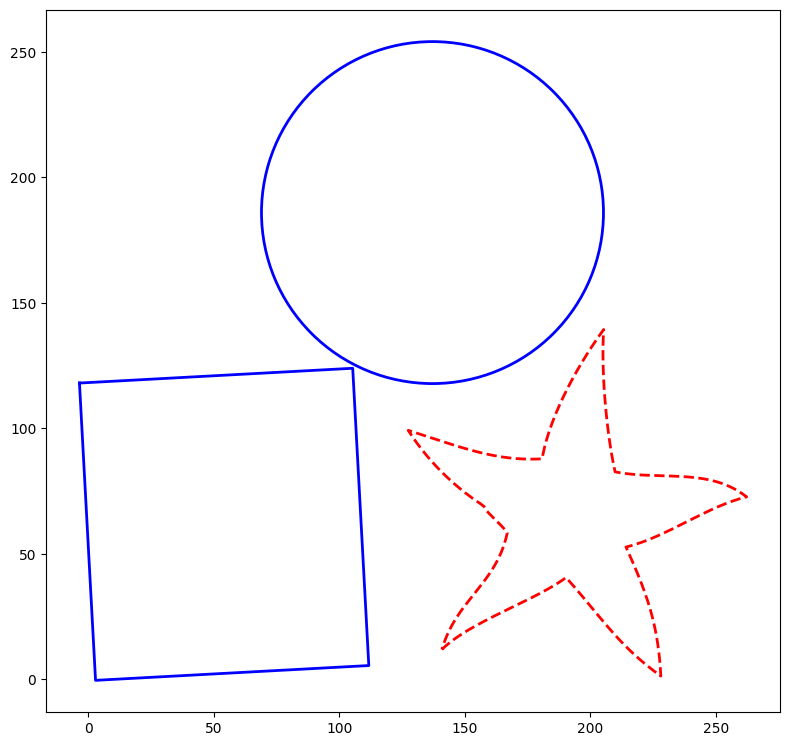

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.spatial import distance, ConvexHull
from sklearn.cluster import DBSCAN
import cv2

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]  # Corrected slicing syntax
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def cluster_shapes(XY, eps=10, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(XY)
    labels = clustering.labels_
    clusters = [XY[labels == i] for i in range(max(labels) + 1)]
    return clusters

def detect_circle(XY):
    def calc_R(xc, yc):
        return np.sqrt((XY[:, 0] - xc)**2 + (XY[:, 1] - yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = np.mean(XY, axis=0)
    center, _ = leastsq(f_2, center_estimate)
    radius = calc_R(*center).mean()
    return center, radius

def detect_rectangle(XY):
    XY = XY.astype(np.float32)
    rect = cv2.minAreaRect(XY)
    box = cv2.boxPoints(rect)
    return box

def detect_star(XY):
    if len(XY) < 10:  # Minimum points to form a star
        return None

    hull = ConvexHull(XY)
    vertices = hull.points[hull.vertices]
    
    # Calculate centroid of the shape
    centroid = np.mean(vertices, axis=0)
    
    # Sort points based on angle from centroid
    angles = np.arctan2(vertices[:, 1] - centroid[1], vertices[:, 0] - centroid[0])
    sorted_vertices = vertices[np.argsort(angles)]
    
    # Calculate distances between consecutive points
    distances = np.linalg.norm(np.diff(sorted_vertices, axis=0, append=[sorted_vertices[0]]), axis=1)
    
    # Check for alternating pattern in distances (indicative of a star)
    if np.std(distances[::2]) < 0.5 * np.mean(distances[::2]) and np.std(distances[1::2]) < 0.5 * np.mean(distances[1::2]):
        return 'star', sorted_vertices
    
    return None

def detect_shape(XY):
    if len(XY) < 5:
        return None

    center, radius = detect_circle(XY)
    error = np.sqrt(np.sum((np.sqrt((XY[:, 0] - center[0])**2 + (XY[:, 1] - center[1])**2) - radius)**2))
    
    if error < 1 * radius:  # Tolerance for circular shape
        return 'circle', center, radius

    rect = detect_rectangle(XY)
    rect_area = cv2.contourArea(rect.astype(np.float32))
    hull = cv2.convexHull(XY.astype(np.float32))
    hull_area = cv2.contourArea(hull)
    if np.abs(rect_area - hull_area) < 0.1 * hull_area:  # Tolerance for rectangle
        return 'rectangle', rect

    star_info = detect_star(XY)
    if star_info:
        return star_info

    return 'other', XY

def redraw_shape(shape_info, ax):
    if shape_info[0] == 'circle':
        center, radius = shape_info[1], shape_info[2]
        circle = plt.Circle(center, radius, color='b', fill=False, linewidth=2)
        ax.add_patch(circle)
    elif shape_info[0] == 'rectangle':
        rect = shape_info[1]
        ax.plot(*np.append(rect, [rect[0]], axis=0).T, 'b-', linewidth=2)
    elif shape_info[0] == 'star':
        star_points = shape_info[1]
        # Draw star by connecting every second vertex
        star_indices = np.arange(len(star_points))
        star_indices = np.roll(star_indices, -1)[::2]
        star_indices = np.append(star_indices, star_indices[0])
        ax.plot(star_points[star_indices, 0], star_points[star_indices, 1], 'g-', linewidth=2)
    elif shape_info[0] == 'other':
        XY = shape_info[1]
        ax.plot(XY[:, 0], XY[:, 1], 'r--', linewidth=2)

def plot(paths_XYs, eps=10, min_samples=5):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            clusters = cluster_shapes(XY, eps=eps, min_samples=min_samples)
            for cluster in clusters:
                shape_info = detect_shape(cluster)
                if shape_info:
                    redraw_shape(shape_info, ax)
    ax.set_aspect("equal")
    plt.show()

# Example usage
csv_path = "./isolated.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)
plot(paths_XYs)

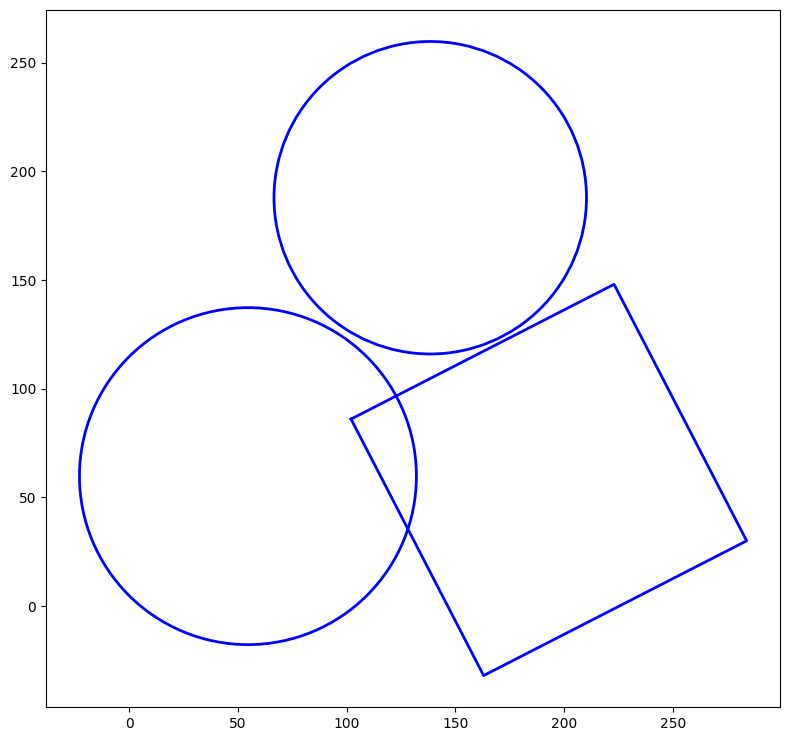

In [28]:
import numpy as np
import cv2
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def detect_star(XY):
    if len(XY) < 10:  # Minimum points to form a star
        return None

    hull = ConvexHull(XY)
    vertices = hull.points[hull.vertices]
    
    # Calculate centroid of the shape
    centroid = np.mean(vertices, axis=0)
    
    # Sort points based on angle from centroid
    angles = np.arctan2(vertices[:, 1] - centroid[1], vertices[:, 0] - centroid[0])
    sorted_vertices = vertices[np.argsort(angles)]
    
    # Calculate distances between consecutive points
    distances = np.linalg.norm(np.diff(sorted_vertices, axis=0, append=[sorted_vertices[0]]), axis=1)
    
    # Check for alternating pattern in distances (indicative of a star)
    if np.std(distances[::2]) < 0.2 * np.mean(distances[::2]) and np.std(distances[1::2]) < 0.2 * np.mean(distances[1::2]):
        return 'star', sorted_vertices
    
    return None

def detect_circle(XY):
    if len(XY) < 5:
        return None, None

    # Fit a circle to the points
    (x, y), radius = cv2.minEnclosingCircle(XY.astype(np.float32))
    center = (x, y)
    
    # Calculate the error of the fit
    distances = np.sqrt((XY[:, 0] - x)**2 + (XY[:, 1] - y)**2)
    error = np.std(distances - radius)
    
    if error < 0.1 * radius:  # Tolerance for circular shape
        return center, radius
    
    return None, None

def detect_rectangle(XY):
    if len(XY) < 4:
        return np.array([])

    # Fit a bounding rectangle to the points
    rect = cv2.minAreaRect(XY.astype(np.float32))
    box = cv2.boxPoints(rect)
    box = np.int32(box)
    
    # Check for right angles
    angles = []
    for i in range(4):
        p1 = box[i]
        p2 = box[(i + 1) % 4]
        p3 = box[(i + 2) % 4]
        v1 = p2 - p1
        v2 = p3 - p2
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        angles.append(np.degrees(angle))
    
    if all(80 <= angle <= 100 for angle in angles):  # Tolerance for right angles
        return box
    
    return np.array([])

def detect_shape(XY):
    if len(XY) < 5:
        return None

    center, radius = detect_circle(XY)
    if center is not None and radius is not None:
        return 'circle', center, radius

    rect = detect_rectangle(XY)
    if rect.size > 0:
        return 'rectangle', rect

    star_info = detect_star(XY)
    if star_info:
        return star_info

    return 'other', XY

def redraw_shape(shape_info, ax):
    if shape_info[0] == 'circle':
        center, radius = shape_info[1], shape_info[2]
        circle = plt.Circle(center, radius, color='b', fill=False, linewidth=2)
        ax.add_patch(circle)
    elif shape_info[0] == 'rectangle':
        rect = shape_info[1]
        ax.plot(*np.append(rect, [rect[0]], axis=0).T, 'b-', linewidth=2)
    elif shape_info[0] == 'star':
        star_points = shape_info[1]
        ax.plot(*np.append(star_points, [star_points[0]], axis=0).T, 'g-', linewidth=2)
    elif shape_info[0] == 'other':
        XY = shape_info[1]
        ax.plot(XY[:, 0], XY[:, 1], 'r--', linewidth=2)

# Example usage remains the same
csv_path = "./isolated.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)
plot(paths_XYs)

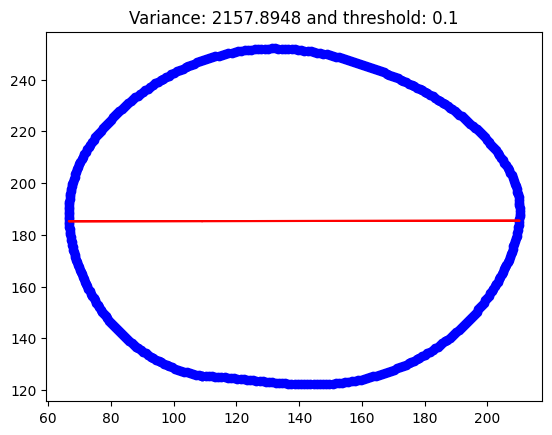

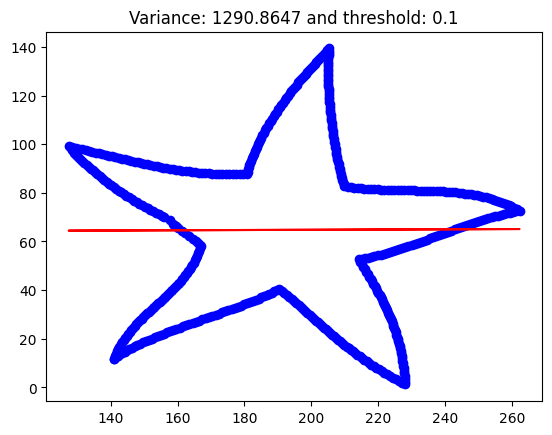

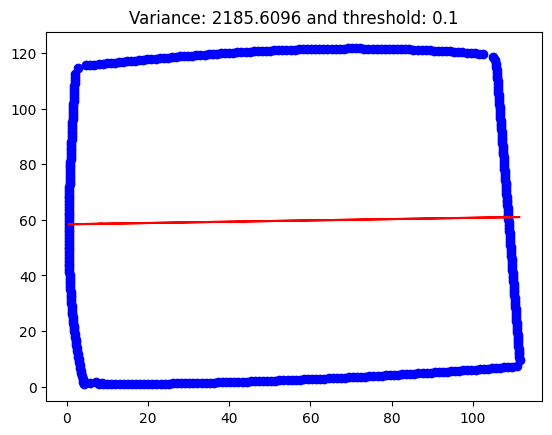

In [29]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

def is_straight_line(XY, threshold=1e-1, plot=False):
    X = XY[:, 0].reshape(-1, 1)
    y = XY[:, 1]

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    residuals = y - y_pred
    variance = np.var(residuals)

    if plot:
        plt.scatter(X, y, color='blue')
        plt.plot(X, y_pred, color='red')
        plt.title(f"Variance: {variance:.4f} and threshold: {threshold}")
        plt.show()

    return variance < threshold, model


# Example usage
for path in paths_XYs:
    for XY in path:
        is_line, model = is_straight_line(XY, plot=True)
        if is_line:
            print("Detected a straight line with slope:", model.coef_[0])

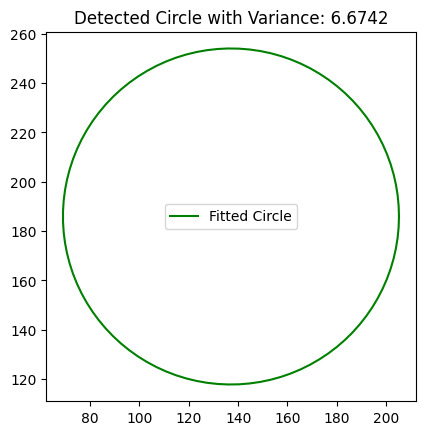

Detected a circle with center: (np.float64(137.08856500488156), np.float64(185.92876404538677)) and radius: 68.13670279805926


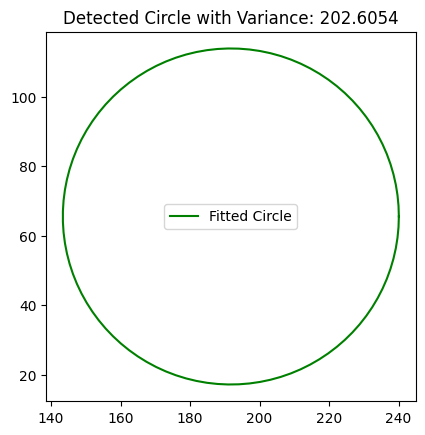

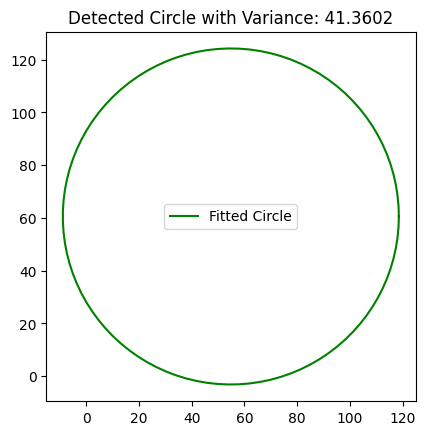

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from sklearn.linear_model import RANSACRegressor

def fit_circle_ransac(XY, plot=False):
    x_m = np.mean(XY[:, 0])
    y_m = np.mean(XY[:, 1])
    
    def calc_R(xc, yc):
        return np.sqrt((XY[:, 0] - xc)**2 + (XY[:, 1] - yc)**2)
    
    def f(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    # Initial circle fitting using least squares
    center_estimate = x_m, y_m
    result = least_squares(f, center_estimate)
    xc, yc = result.x
    Ri = calc_R(xc, yc)
    R = Ri.mean()
    residuals = Ri - R
    
    # Use RANSAC to improve robustness against outliers
    ransac = RANSACRegressor(residual_threshold=np.percentile(np.abs(residuals), 50))
    X_ransac = XY[:, 0].reshape(-1, 1)
    y_ransac = XY[:, 1]
    ransac.fit(X_ransac, y_ransac)
    
    inlier_mask = ransac.inlier_mask_
    XY_inliers = XY[inlier_mask]
    
    # Refit the circle with inliers
    x_m_inliers = np.mean(XY_inliers[:, 0])
    y_m_inliers = np.mean(XY_inliers[:, 1])
    center_estimate = x_m_inliers, y_m_inliers
    result = least_squares(f, center_estimate)
    xc, yc = result.x
    Ri = calc_R(xc, yc)
    R = Ri.mean()
    residuals = Ri - R
    variance = np.var(residuals)

    if plot:
        theta = np.linspace(0, 2 * np.pi, 100)
        circle_x = xc + R * np.cos(theta)
        circle_y = yc + R * np.sin(theta)
        
        plt.figure()
        plt.plot(circle_x, circle_y, 'green', label='Fitted Circle')
        # plt.scatter(XY[:, 0], XY[:, 1], label='Data Points')
        # plt.scatter([xc], [yc], color='blue', label='Center')
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(f"Detected Circle with Variance: {variance:.4f}")
        plt.show()

    return (xc, yc), R, variance

def is_circle(XY, threshold=10, plot=False):
    center, radius, variance = fit_circle_ransac(XY, plot=plot)
    return variance < threshold, center, radius

# Example usage with plotting
for path in paths_XYs:
    for XY in path:
        is_circ, center, radius = is_circle(XY, plot=True)
        if is_circ:
            print(f"Detected a circle with center: {center} and radius: {radius}")


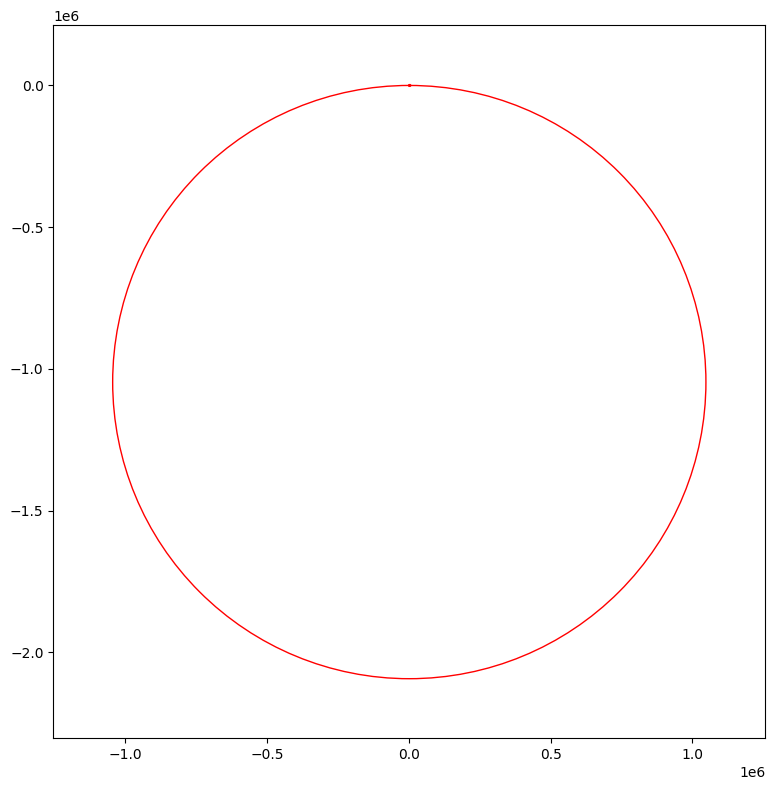

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_detected_shapes(paths_XYs, detected_shapes, buffer=0.1):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    # Initialize limits
    x_min, x_max = np.inf, -np.inf
    y_min, y_max = np.inf, -np.inf

    for shape in detected_shapes:
        if shape['type'] == 'line':
            model = shape['model']
            x_vals = np.array(ax.get_xlim())
            y_vals = model.coef_[0] * x_vals + model.intercept_
            ax.plot(x_vals, y_vals, '--', color='red')
        elif shape['type'] == 'circle':
            center, radius = shape['center'], shape['radius']
            x_min = min(x_min, center[0] - radius)
            x_max = max(x_max, center[0] + radius)
            y_min = min(y_min, center[1] - radius)
            y_max = max(y_max, center[1] + radius)
            circle = plt.Circle(center, radius, color='red', fill=False, linestyle='-')
            ax.add_artist(circle)
        else:
            ax.plot(shape['xy'][:, 0], shape['xy'][:, 1], linewidth=1, color='red')
            # Update limits based on other shapes
            x_min = min(x_min, np.min(shape['xy'][:, 0]))
            x_max = max(x_max, np.max(shape['xy'][:, 0]))
            y_min = min(y_min, np.min(shape['xy'][:, 1]))
            y_max = max(y_max, np.max(shape['xy'][:, 1]))

    # Apply buffer to limits
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_buffer = x_range * buffer
    y_buffer = y_range * buffer

    ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
    ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
    
    ax.set_aspect('equal')
    plt.show()

# Example usage
detected_shapes = []
for path in paths_XYs:
    for XY in path:
        is_line, model = is_straight_line(XY)
        if is_line:
            detected_shapes.append({'type': 'line', 'model': model})

        is_circ, center, radius = is_circle(XY)
        if is_circ:
            detected_shapes.append({'type': 'circle', 'center': center, 'radius': radius})
        else:
            detected_shapes.append({'type': 'other', 'xy': XY})

plot_detected_shapes(paths_XYs, detected_shapes)


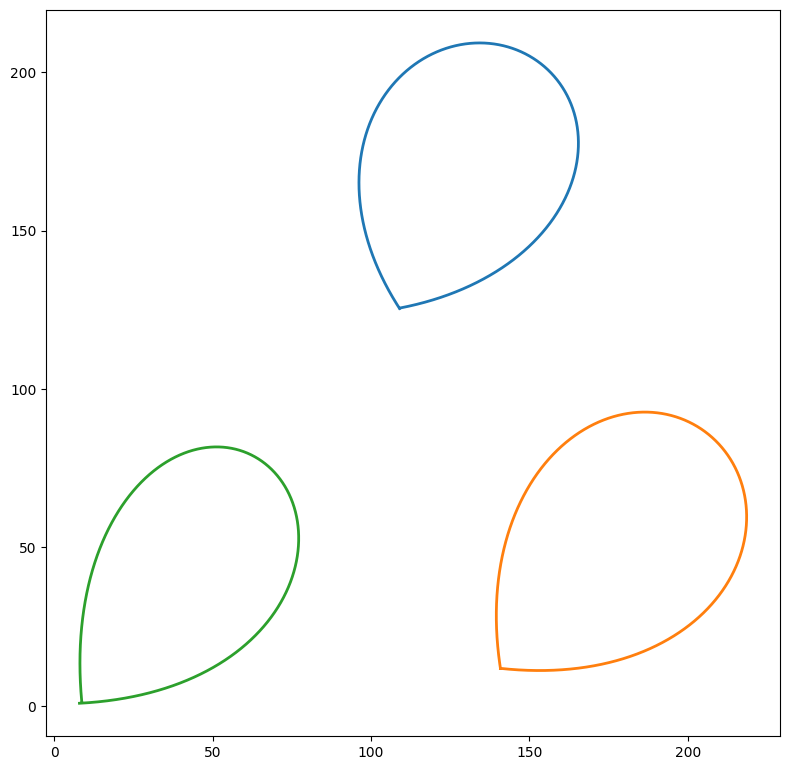

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import bezier
from sklearn.linear_model import LinearRegression

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def normalize_with_bezier(XY, num_points=100000, degree=10000):
    if XY.shape[0] < degree + 1:
        raise ValueError(f"Input data must have at least {degree + 1} points to create a degree {degree} Bezier curve.")
    
    # Select nodes for the Bezier curve
    indices = np.linspace(0, len(XY) - 1, degree + 1, dtype=int)
    selected_nodes = XY[indices]
    
    nodes = np.asfortranarray(selected_nodes.T)
    curve = bezier.Curve(nodes, degree=degree)
    s_vals = np.linspace(0.0, 1.0, num_points)
    normalized_XY = curve.evaluate_multi(s_vals).T
    return normalized_XY

def is_straight_line(XY, threshold=1e-1):
    X = XY[:, 0].reshape(-1, 1)
    y = XY[:, 1]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    residuals = y - y_pred
    variance = np.var(residuals)
    return variance < threshold, model

# Example usage
csv_path = "./isolated.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)

# Normalize curves with higher degree Bezier
normalized_paths_XYs = []
for path in paths_XYs:
    normalized_path = [normalize_with_bezier(XY, degree=5) for XY in path]
    normalized_paths_XYs.append(normalized_path)

# Detect shapes
detected_shapes = []
for path in normalized_paths_XYs:
    for XY in path:
        is_line, model = is_straight_line(XY)
        if is_line:
            detected_shapes.append({'type': 'line', 'model': model})

# Plot detected shapes
plot_detected_shapes(normalized_paths_XYs, detected_shapes)